<a href="https://colab.research.google.com/github/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning/blob/main/GB888_VII_6_TextClassExampleViaLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification via LSTM Networks


In this tutorial, we go through the same text classification example from before. To recall: We rely on (a sllightly reduced version of) the **AG News Classification Dataset** (see here), which contains news articles, their titles, and what type of article it is (class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech).

In contrast to before, though, we are using a more advanced network design, namely a LSTM network, the we had discussed.

As usually, let's start with loading the relevant libaries.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D

And let's import the dataset:

In [ ]:
!git clone https://github.com/danielbauer1979/MSDIA_PredictiveModelingAndMachineLearning.git

Cloning into 'MSDIA_PredictiveModelingAndMachineLearning'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 361 (delta 69), reused 15 (delta 15), pack-reused 253 (from 2)
Receiving objects: 100% (361/361), 49.69 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Updating files: 100% (80/80), done.


In [37]:
News = pd.read_csv('MSDIA_PredictiveModelingAndMachineLearning/GB888_VII_3_TextClassExample.csv', index_col=0)

In [ ]:
News.head()

,Title,Description
Class Index,,
4,IBM seeks dismissal in second part of SCO case,In documents filed Friday with the U.S. Distri...
2,Wary Martin gets the drop on Loeb,"The Estonian Markko Martin, a candidate for th..."
2,Canas beats Burgsmuller to capture Shanghai title,SHANGHAI: Argentinas Guillermo Canas thrashed ...
2,Manchester United: The richest and possibly mo...,"Manchester United, which said on Monday it had..."
1,Leaders of 25 EU Countries Sign New Constitution,Leaders of the 25-nation European Union today ...


## Prepare and Clean the Data

We start by preparing the text data. As opposed to before, we now need a different processing. In particular, we want to preserve the order (and the context) of the sentences. Still, consistency is desirable.

We first reset the "Index" (because the first column really is a category), coerce it to be between 0 and 3, and make it a class variable:

In [38]:
News = News.reset_index()
News = News.rename(columns={"Class Index": "Category"})
News['Category'] = News['Category'] - 1
News.head()

,Category,Title,Description
0,3,IBM seeks dismissal in second part of SCO case,In documents filed Friday with the U.S. Distri...
1,1,Wary Martin gets the drop on Loeb,"The Estonian Markko Martin, a candidate for th..."
2,1,Canas beats Burgsmuller to capture Shanghai title,SHANGHAI: Argentinas Guillermo Canas thrashed ...
3,1,Manchester United: The richest and possibly mo...,"Manchester United, which said on Monday it had..."
4,0,Leaders of 25 EU Countries Sign New Constitution,Leaders of the 25-nation European Union today ...


Then, let's again combine the Title and Description columns:

In [39]:
News['Combined'] = News['Title'] + ' ' + News['Description']
News = News.drop(['Title', 'Description'], axis=1)
News.head()

,Category,Combined
0,3,IBM seeks dismissal in second part of SCO case...
1,1,Wary Martin gets the drop on Loeb The Estonian...
2,1,Canas beats Burgsmuller to capture Shanghai ti...
3,1,Manchester United: The richest and possibly mo...
4,0,Leaders of 25 EU Countries Sign New Constituti...


In [40]:
X = News['Combined']
y = News['Category']

Again, we want to preserve the order in this case. However, we still carry out two steps: **Tokenization** and **Padding**


* **Tokenization** is common in Natural Language Processing (NLP). Essentially, we take big or combined words and separate them into pieces called **tokens**. Often tokens correspond to full words, but it can also correspond to subwords (e.g., removing "-er" in "faster" or "-ly" in "quickly"). However, unkike in *stemming** before, we now we keep the tokens intact (but can use the idea that "fast" is used as a comparative). Tokens are then often assigned a number so that we can represent a text fragment as a sequence of numbers corresponding to tokens.

* ML models require inputs that have the same shape and size. However, not all the news articles have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the **padding** is necessary.


We use a tokenizer from Keras:

In [42]:
vocab_size = 10000 # arbitrarily chosen
embed_size = 32 # arbitrarily chosen

# Create and Fit tokenizer
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X.values)

The Tokenizer now has tokens in it and gives each of them a number:

In [43]:
tok.word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 '39': 9,
 's': 10,
 'that': 11,
 'with': 12,
 'as': 13,
 'at': 14,
 'its': 15,
 'is': 16,
 'new': 17,
 'by': 18,
 'said': 19,
 'it': 20,
 'reuters': 21,
 'has': 22,
 'from': 23,
 'an': 24,
 'ap': 25,
 'his': 26,
 'will': 27,
 'after': 28,
 'was': 29,
 'gt': 30,
 'lt': 31,
 'us': 32,
 'be': 33,
 'over': 34,
 'have': 35,
 'up': 36,
 'their': 37,
 'two': 38,
 'first': 39,
 'are': 40,
 'quot': 41,
 'year': 42,
 'but': 43,
 'more': 44,
 'he': 45,
 'u': 46,
 '1': 47,
 'this': 48,
 'one': 49,
 'world': 50,
 'oil': 51,
 'monday': 52,
 'out': 53,
 'wednesday': 54,
 'tuesday': 55,
 'thursday': 56,
 'company': 57,
 'not': 58,
 '2': 59,
 'against': 60,
 'inc': 61,
 'friday': 62,
 'than': 63,
 'into': 64,
 'last': 65,
 'about': 66,
 'b': 67,
 'they': 68,
 'york': 69,
 'who': 70,
 'three': 71,
 'yesterday': 72,
 'no': 73,
 'president': 74,
 'iraq': 75,
 'million': 76,
 'were': 77,
 'game': 78,
 'microsoft': 79,
 'been

We can now convert the text sequence to numbers. Note that they have speficic meaning based on the initialization:

In [44]:
X = tok.texts_to_sequences(X)

Let's look at the first element:

In [45]:
X[0]

[215,
 1048,
 7763,
 5,
 105,
 368,
 4,
 4172,
 394,
 5,
 2035,
 938,
 62,
 12,
 1,
 46,
 10,
 2171,
 161,
 8,
 1,
 2171,
 4,
 1835,
 215,
 2221,
 1,
 7763,
 4,
 3,
 201,
 5274,
 4,
 1,
 999,
 938,
 60,
 20,
 65,
 42,
 18,
 1,
 4172,
 99]

Look above: The fourth word is "in" which has token number 5. The seventh word is "of" which has token number 4.

Let's check how long the sequences are:

In [46]:
max_len = 0
max_len_index = 0

for i, seq in enumerate(X):
  if len(seq) > max_len:
    max_len = len(seq)
    max_len_index = i

print(f"The vector with the most elements is at index {max_len_index} with {max_len} elements.")

The vector with the most elements is at index 24253 with 174 elements.


In [47]:
X = pad_sequences(X, maxlen=max_len)

So, now `X` will consist of input sequences of the same length. And the numbers in the sequences will correspond to tokens. The tokens feal kind of arbitrary (how do we know if two words/tokens are related?). As we will see, we will map each token to a vector via an embedding.

## ML Modeling

So let's do some ML. We start by splitting our data into a training and test set

In [48]:
y = to_categorical(y,4)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

To "learn" the relevance of tokens in sequence (and, e.g., whether the "international" aspects of a story or the "sports" aspects of a story dominate), we can rely on an RNN. We will use a LSTM. Our design is as follows:

* We use an [*Embedding*](https://keras.io/api/layers/core_layers/embedding/) layer that maps the tokenized input (so each word, kind of) to a vector of size 32 (as defined by `embed_size`). The input_dim is set to 10,000, which is the size of our vocabulary.
* Two LSTM Layers. Note that we could also include Bidirectional layers
* A pooling Layer in the LSTM output decreases sensitivity to features, thereby creating more generalised data for better test results.
* Dropout layer nullifies certain random input values to generate a more general dataset and prevent overfitting.
* As before, a softmax output layer.

Let's try:

In [50]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim=embed_size,input_length=10,input_shape=(max_len,)))
model.add(LSTM(128, return_sequences=True))
#model.add(Bidirectional(LSTM(128, return_sequences=True))) # for bi-directional
model.add(LSTM(64, return_sequences=True))
model.add(GlobalMaxPooling1D()) #
model.add(Dense(64))
model.add(Dropout(0.25)) #
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 174, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 174, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 174, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_4               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,212 (1.75 MB)

 Trainable params: 458,212 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

So, we have a high-dimensional model. Let's see how well it performs.

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model.fit(X_train,
          y_train,
          batch_size=256,
          validation_data=(X_test, y_test),
          epochs=20)

Epoch 1/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 429s 2s/step - accuracy: 0.6409 - loss: 0.8142 - val_accuracy: 0.8945 - val_loss: 0.3156
Epoch 2/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9150 - loss: 0.2710 - val_accuracy: 0.8975 - val_loss: 0.3006
Epoch 3/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 423s 2s/step - accuracy: 0.9310 - loss: 0.2158 - val_accuracy: 0.8991 - val_loss: 0.2989
Epoch 4/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.9427 - loss: 0.1789 - val_accuracy: 0.9022 - val_loss: 0.2974
Epoch 5/20
274/274 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.9498 - loss: 0.1548 - val_accuracy: 0.8995 - val_loss: 0.3136
Epoch 6/20


KeyboardInterrupt: 

Let's again check the performance:

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

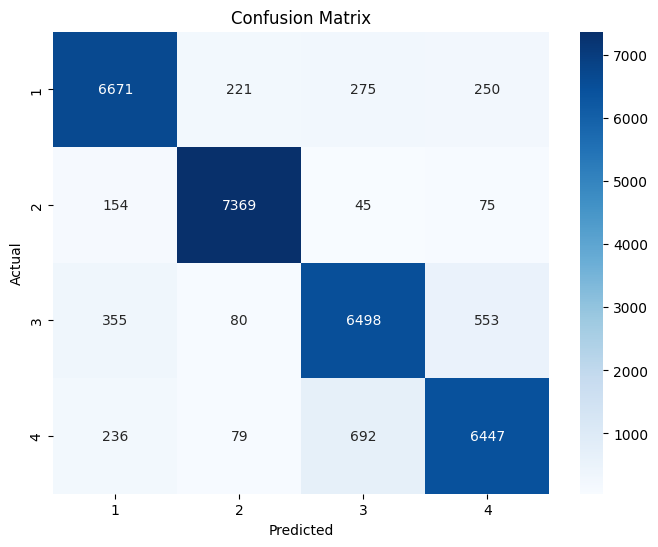

Accuracy: 0.8995


In [63]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy}")

So, overall, not really an improvement relative to the simple model. Clearly, we could experiment. But in this application, it seems the LSTM doesn't buy us much here...